# Fit AdapIF to HH Spike Trains

In [1]:
from brian2 import *
from brian2modelfitting import *

import numpy as np

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]
WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
 [py.warnings]


In [2]:
dt = 0.01*ms
defaultclock.dt = dt

## Load the Data

In [3]:
voltage1 = genfromtxt('voltage1nA.csv', delimiter=',')
voltage2 = genfromtxt('voltage2nA.csv', delimiter=',')

In [4]:
inp_cur1 = genfromtxt('inp_cur1nA.csv', delimiter=',')
inp_cur2 = genfromtxt('inp_cur2nA.csv', delimiter=',')
inp_current = [inp_cur1, inp_cur2]
inp_current

[array([ 0.        , -0.01416314,  0.06263459, ..., -0.44478035,
        -0.39163954, -0.33014548]),
 array([ 0.        ,  0.39594954,  0.27878635, ..., -0.55344109,
        -0.71057181, -0.62256885])]

In [5]:
out_spikes1 = genfromtxt('out_spikes1nA.csv', delimiter=',')
out_spikes2 = genfromtxt('out_spikes2nA.csv', delimiter=',')
out_spikes = [out_spikes1, out_spikes2]
# out_spikes

## Model Fitting

In [6]:
# tau = 12.44*ms
# taut = 97.64*ms
# a = 0.21
# alpha = 7.2*mV
# R = 76*Mohm

model = '''
        dv/dt = (R*I- v)/tau : 1
        dvt/dt = (a*v - vt) / taut :1
        alpha : 1 (constant)
        a : 1 (constant)
        R : 1/amp (constant)
        tau : second (constant)
        taut : second (constant)
        '''

reset = '''
v = 0
vt = vt + alpha
'''

In [7]:
set_device('cpp_standalone', directory='parallel2', clean=False)

In [8]:
n_opt = NevergradOptimizer()
metric = GammaFactor(time=50*second, delta=4*ms)

In [9]:
fitter = SpikeFitter(model=model, input_var='I', dt=dt,
                     input=inp_current * nA, output=out_spikes,
                     n_samples=60,
                     threshold='v > 1 + vt',
                     reset=reset,
                     refractory=2*ms,
                     )

exponential_euler


In [10]:
result_dict, error = fitter.fit(n_rounds=20,
                                optimizer=n_opt,
                                metric=metric,
                                callback='text',
                                alpha=[0.1, 2],
                                a = [0.001, 0.1],
                                R = [1, 15] * 1/nA, 
                                tau = [7, 15]*ms,
                                taut = [30, 100]*ms,
                               )

Round 0: fit (1.0567945343711835, 0.053181121850389576, 10264813709.390064, 0.069178946674303, 0.012791553131362429) with error: 0.011947383725283645
Round 1: fit (1.0685307769585064, 0.056089035183282406, 8521471260.239326, 0.0785213451006641, 0.010278200375259844) with error: 0.011947383725283645
Round 2: fit (1.0567945343711835, 0.053181121850389576, 10264813709.390064, 0.05993063596720369, 0.012791553131362429) with error: 0.0033298324215976782
Round 3: fit (1.0567945343711835, 0.053181121850389576, 10264813709.390064, 0.05993063596720369, 0.012791553131362429) with error: 0.0033298324215976782
Round 4: fit (1.0567945343711835, 0.053181121850389576, 10264813709.390064, 0.05993063596720369, 0.012791553131362429) with error: 0.0033298324215976782
Round 5: fit (1.0567945343711835, 0.053181121850389576, 10264813709.390064, 0.05993063596720369, 0.012791553131362429) with error: 0.0033298324215976782
Round 6: fit (1.0468783271310453, 0.05271348279049591, 10306952159.709137, 0.06849696412

In [11]:
result_dict

{'alpha': 0.9062755090026456,
 'taut': 0.06178249263034064,
 'R': 10647015878.988583,
 'a': 0.08125667702533687,
 'tau': 0.013454609829357532}

In [12]:
print('a', result_dict['a'])
print('tau', in_unit(result_dict['tau']*second, ms))
print('R', result_dict['R'])
print('taut', in_unit(result_dict['taut']*second, ms))
print('alpha', result_dict['alpha'])

a 0.08125667702533687
tau 13.45460983 ms
R 10647015878.988583
taut 61.78249263 ms
alpha 0.9062755090026456


In [13]:
error

0.0024690871014746985

In [14]:
1 - error

0.9975309128985252

In [15]:
device.reinit()
device.activate()

In [16]:
# visualization of the results
spikes = fitter.generate_spikes(params=None)
# print('spike times:', spikes)

exponential_euler


In [17]:
print(len(out_spikes[0]))
print(len(spikes[0]))

918
1062


In [18]:
print(len(out_spikes[1]))
print(len(spikes[1]))

1505
0


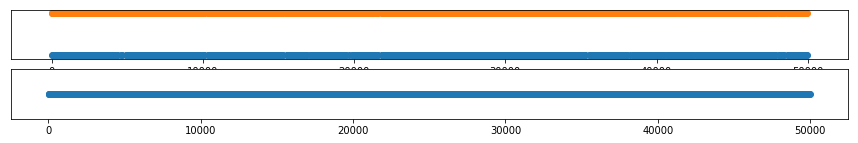

In [19]:
d=-1

fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

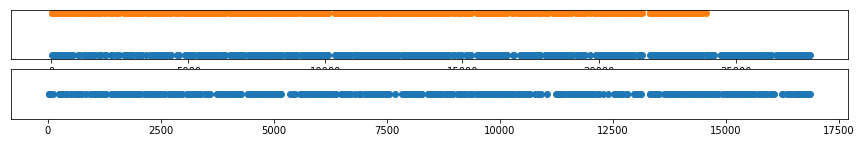

In [20]:
d=500


fig, ax = plt.subplots(nrows=2, figsize=(15,2))

ax[0].set_yticks(np.arange(0, 1, step=1))
ax[0].scatter(out_spikes[0][:d], np.ones_like(out_spikes[0][:d]));
ax[0].scatter(spikes[0][:d], np.ones_like(spikes[0][:d])*2);

ax[1].set_yticks(np.arange(0, 1, step=1))
ax[1].scatter(out_spikes[1][:d], np.ones_like(out_spikes[1][:d]));
ax[1].scatter(spikes[1][:d], np.ones_like(spikes[1][:d])*2);

In [21]:
device.reinit()
device.activate()

In [22]:
fits = fitter.generate(params=None, output_var='v',)

exponential_euler


In [23]:
# fig, ax = plt.subplots(nrows=2, figsize=(15,10))

# ax[0].plot(voltage1);
# ax[0].plot(fits[0]/mV)

# ax[1].plot(voltage2);
# ax[1].plot(fits[1]/mV);


In [24]:
t0 = np.arange(0, len(voltage1)*dt, dt)
t_ = spikes[0]
t = spikes[0][t_<3000]

In [25]:
t

array([   9.66,   11.83,   84.81,   90.62,  154.29,  177.  ,  205.42,
        265.3 ,  290.15,  368.6 ,  411.25,  499.03,  506.27,  523.7 ,
        581.18,  590.55,  624.94,  686.87,  784.69,  853.11,  967.06,
        973.91, 1030.01, 1178.63, 1184.51, 1204.82, 1276.84, 1313.58,
       1374.05, 1406.63, 1420.68, 1463.72, 1513.17, 1516.12, 1597.13,
       1599.77, 1716.01, 1743.1 , 1814.4 , 1941.75, 1958.5 , 1984.93,
       2123.93, 2175.79, 2179.94, 2197.45, 2217.35, 2344.55, 2417.  ,
       2421.4 , 2426.84, 2450.74, 2647.97, 2684.37, 2728.89, 2790.51,
       2810.89, 2857.63, 2862.94, 2886.43, 2922.94, 2975.48, 2986.67])

In [34]:
os = array(out_spikes[0])
os[os<3000]

array([  10.85,   86.77,  152.87,  177.99,  206.49,  255.46,  289.97,
        351.57,  372.45,  411.88,  501.64,  514.26,  569.2 ,  588.26,
        617.37,  659.91,  705.57,  796.7 ,  968.93, 1029.32, 1179.85,
       1201.26, 1277.75, 1314.76, 1374.47, 1408.51, 1422.03, 1462.08,
       1485.98, 1514.33, 1597.82, 1717.75, 1744.83, 1814.92, 1943.69,
       1985.12, 2178.47, 2198.5 , 2217.57, 2345.9 , 2418.41, 2427.14,
       2450.77, 2650.41, 2686.33, 2729.71, 2792.29, 2818.29, 2859.09,
       2884.83, 2922.46, 2975.51, 2988.59])

In [26]:
v = fits[0]
d = 300000

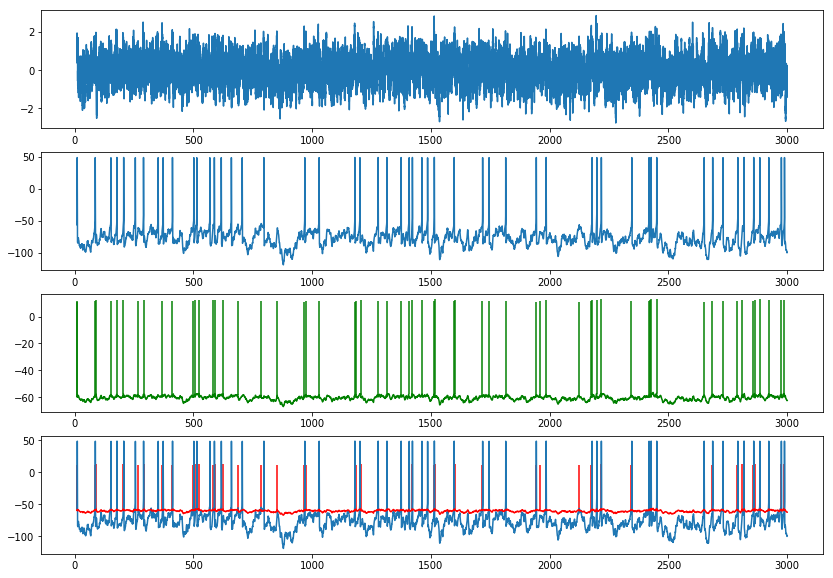

In [28]:
fig, ax = plt.subplots(nrows=4, figsize=(14,10))
ax[0].plot(t0[1000:d]/ms, inp_cur1[1000:d]);
ax[1].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[2].plot(t0[1000:d]/ms, v[1000:d]-60, 'g')
ax[2].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'g');

ax[3].plot(t0[1000:d]/ms, voltage1[1000:d]);
ax[3].plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
ax[3].vlines(t, v[np.int_(np.round(t/dt*ms))]+10, v[np.int_(np.round(t/dt*ms))]-60, 'r');



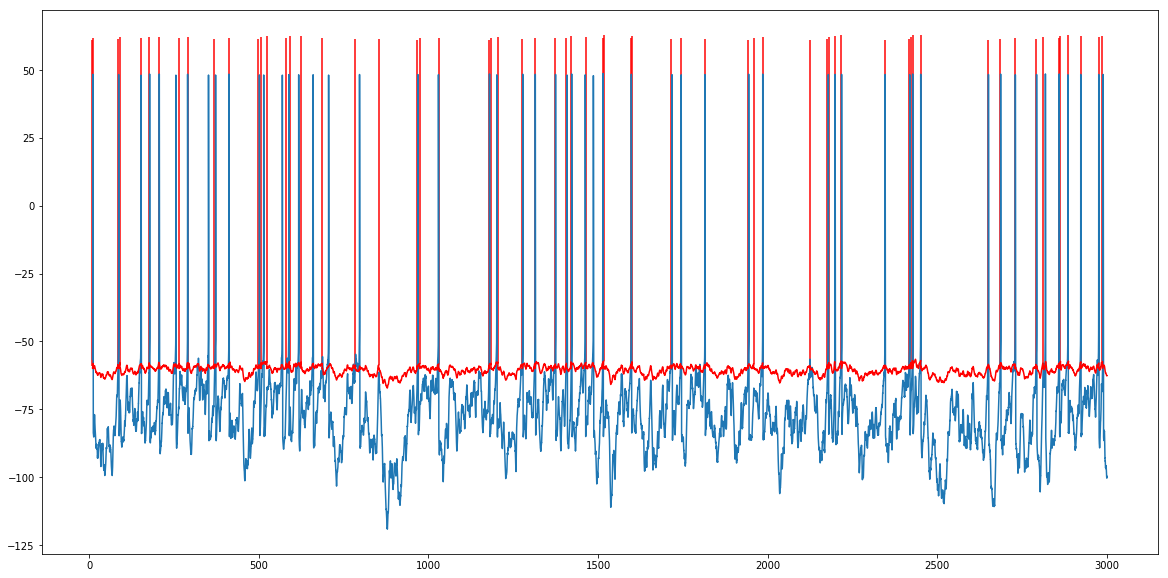

In [36]:
plt.figure(figsize=(20,10))
plot(t0[1000:d]/ms, voltage1[1000:d]);
plot(t0[1000:d]/ms, v[1000:d]-60, 'r')
vlines(t, v[np.int_(np.round(t/dt*ms))]+60, v[np.int_(np.round(t/dt*ms))]-60, 'r');
